In [1]:
import sys
sys.path.append("../")
from mfmodeling import NARGP, SingleGP
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy.spatial import distance
import pickle

2025-09-26 06:43:59.934017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 06:44:01.484169: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maeyama/mylib/Miniforge3/envs/dps_3.12.11/lib/python3.12/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resource

### Read dataset
Split the train and test dataset in an extrapolative setup.   
The train data set has large D_exp values, while the test data has small D_exp values.

In [2]:
df = pd.read_csv("./data/JET_data_Narita2023CPP_fig1.csv")
df = df[df["D_exp"]>0].copy()
print(df.columns)

D_exp_threshold = df["D_exp"].median()

df_train = df[df["D_exp"]>D_exp_threshold].copy()
df_test = df[df["D_exp"]<=D_exp_threshold].copy()
print(df.shape)
print(df_train.shape)
print(df_test.shape)

Index(['R/Ln', 'R/LTe', 'R/LTi', 'ni/ne', 'Te/Ti', 'beta', 'nu_ee', 'q', 's',
       'epsilon', 'kappa', 'delta', 'C_T', 'C_P', 'C_N', 'C_HP',
       'chi_e_eff/chi_i_eff', 'ktheta', 'gamma', 'D_exp', 'Q_e_exp'],
      dtype='object')
(135, 21)
(67, 21)
(68, 21)


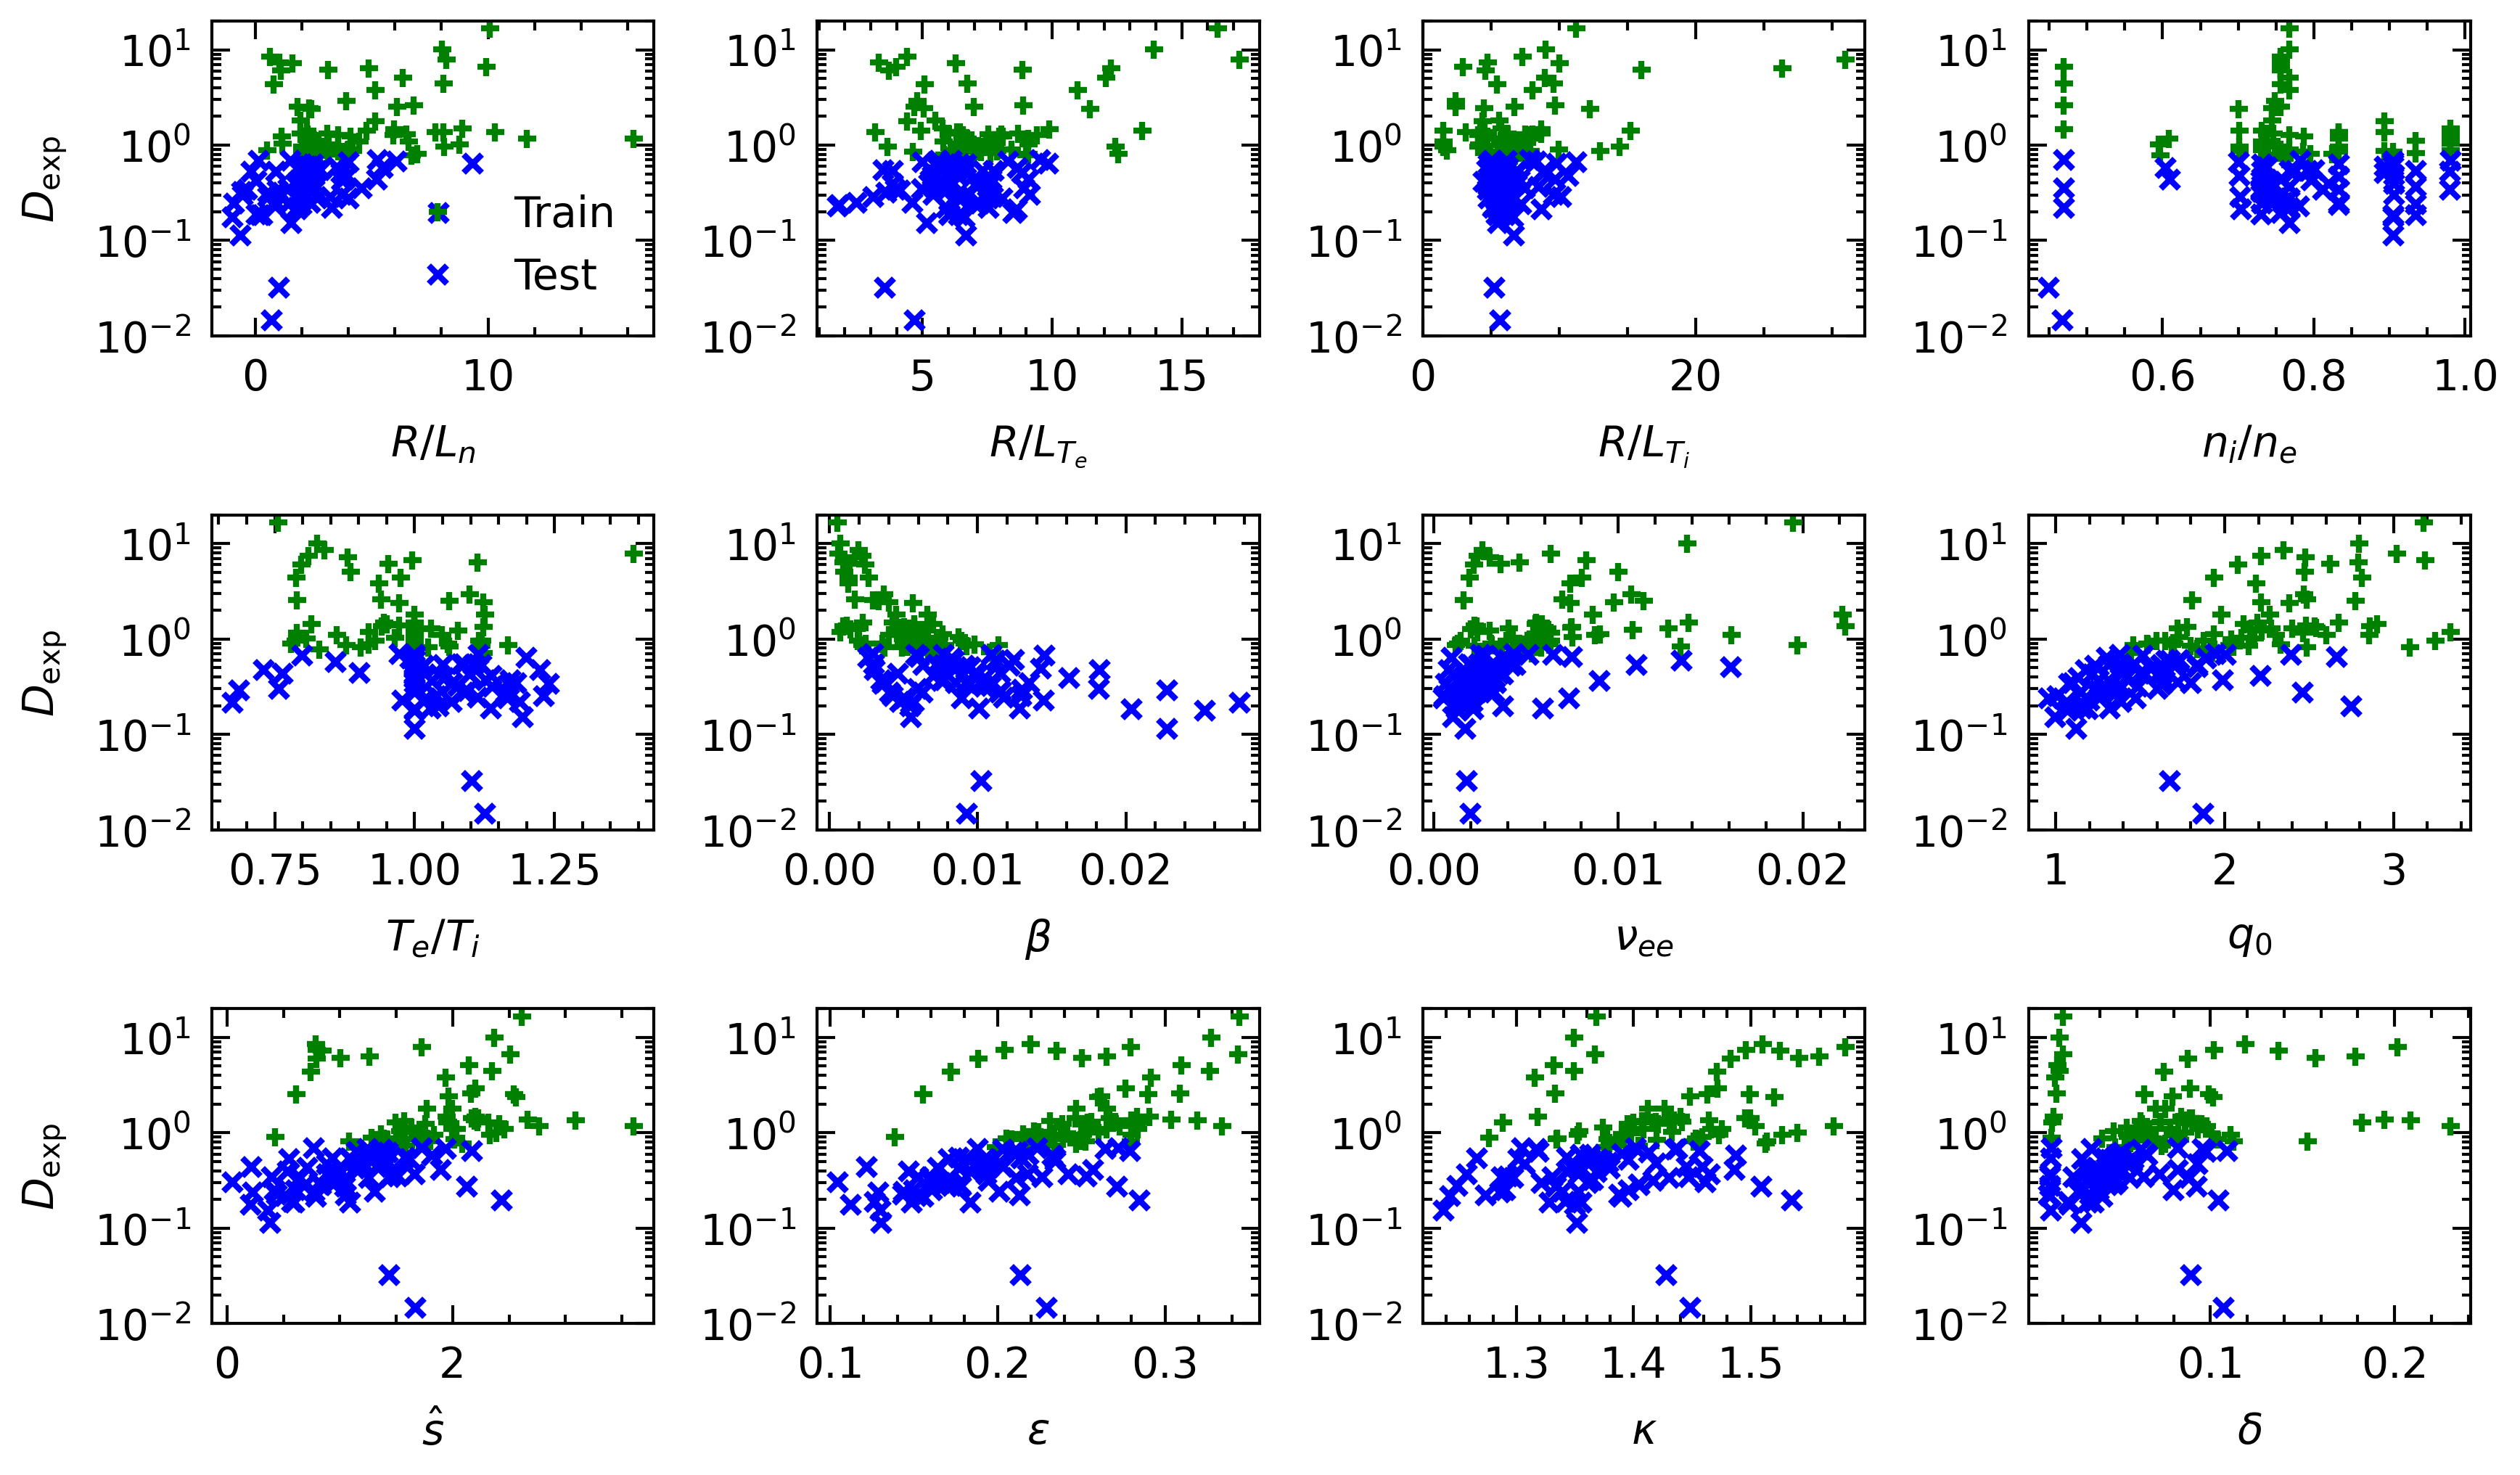

In [3]:
plt.style.use('../nature_style.txt')

fig=plt.figure(figsize=(5.9,3.5),dpi=600) # figsize=(width,height(inch)),dpi(dots per inch)

xlabels = [r"$R/L_n$", r"$R/L_{T_e}$", r"$R/L_{T_i}$", r"$n_i/n_e$", r"$T_e/T_i$", r"$\beta$", r"$\nu_{ee}$", r"$q_0$", r"$\hat{s}$", r"$\epsilon$", r"$\kappa$", r"$\delta$"]
text = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)", "(l)"]
# fig.suptitle("D_exp")
nl=3; nc=4; i=0
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        # ax.plot(df.iloc[:,i],df["D_exp"],"x",label="All data")
        ax.plot(df_train.iloc[:,i],df_train["D_exp"],"g+",lw=1,label="Train")
        ax.plot(df_test.iloc[:,i],df_test["D_exp"],"bx",lw=1,label="Test")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[0]],np.array(df_test["D_exp"])[outliner_list[0]],"x",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[1]],np.array(df_test["D_exp"])[outliner_list[1]],"*",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[2]],np.array(df_test["D_exp"])[outliner_list[2]],"^",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[3]],np.array(df_test["D_exp"])[outliner_list[3]],"s",c="red",label="Outliner")
        ax.set_xlabel(xlabels[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(D_min,D_max)
        # if i==7 or i==9 or i==10:
        #     ax.text(0.05, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        # else:
        #     ax.text(0.835, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        if c==0:
            ax.set_ylabel(r"$D_\mathrm{exp}$")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.show() 

### Evaluation of Mahalanobis distance
Test data near from train data can be accurately predicted, while the test data far from the train data can be poorly extrapolated.

In [4]:
from scipy.spatial import distance
test_points = np.concatenate([df_test.iloc[:,0:12],df_test.iloc[:,19:20]],axis=1)
train_points = np.concatenate([df_train.iloc[:,0:12],df_train.iloc[:,19:20]],axis=1)
all_points = np.concatenate([df.iloc[:,0:12],df.iloc[:,19:20]],axis=1)
covariance_matrix = np.cov(all_points.T)
#inv_covariance_matrix = np.linalg.inv(covariance_matrix)
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)

distances_of_test_from_train = np.array([distance.mahalanobis(x, y, inv_covariance_matrix)
                                         for x in test_points for y in train_points])
print(test_points.shape,train_points.shape,distances_of_test_from_train.shape)
distances_of_test_from_train = distances_of_test_from_train.reshape(test_points.shape[0], len(train_points))
print(distances_of_test_from_train.shape)
min_distances_of_test_from_train_dataset = np.min(distances_of_test_from_train, axis=1)
print(min_distances_of_test_from_train_dataset.shape)

threshold_distance = 2.8
far_list = min_distances_of_test_from_train_dataset > threshold_distance
near_list = min_distances_of_test_from_train_dataset <= threshold_distance

# plt.plot(min_distances_of_test_from_train_dataset)
# plt.plot(np.arange(len(far_list))[far_list],min_distances_of_test_from_train_dataset[far_list],"x",c="red")
# plt.plot(np.arange(len(near_list))[near_list],min_distances_of_test_from_train_dataset[near_list],".",c="green")
# plt.show()

(68, 13) (67, 13) (4556,)
(68, 67)
(68,)


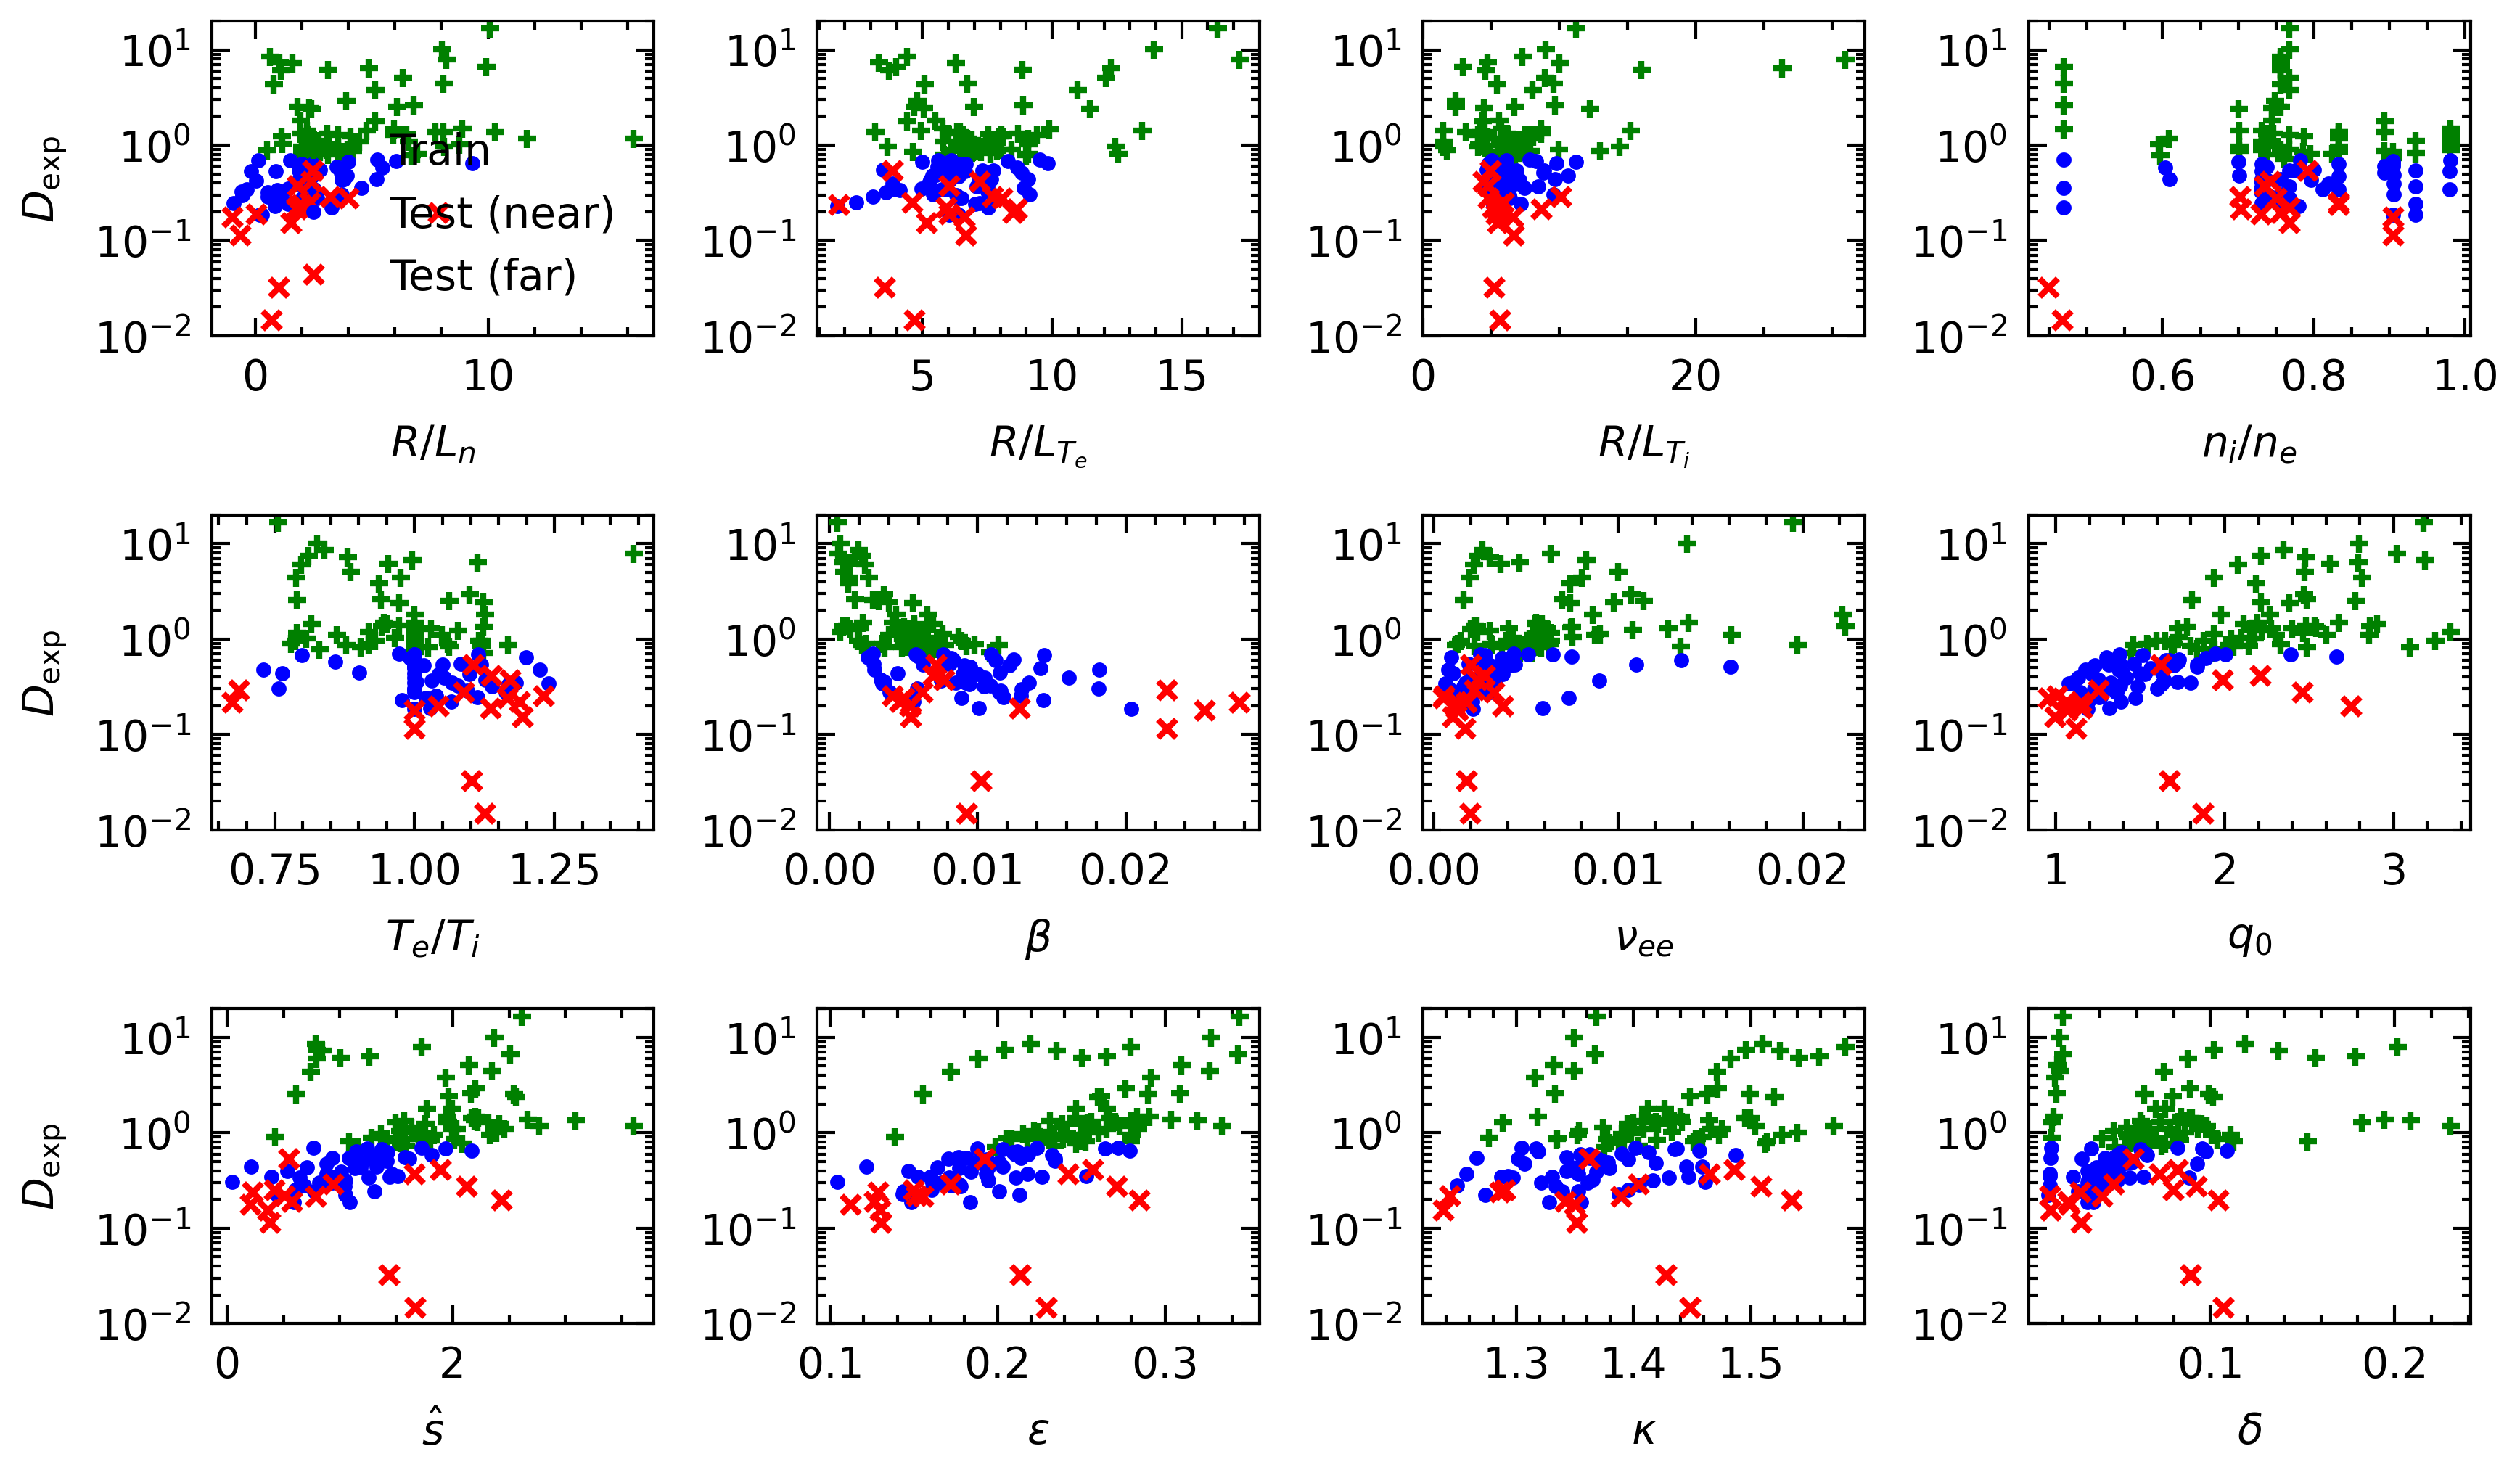

In [5]:
plt.style.use('../nature_style.txt')

fig=plt.figure(figsize=(5.9,3.5),dpi=600) # figsize=(width,height(inch)),dpi(dots per inch)

xlabels = [r"$R/L_n$", r"$R/L_{T_e}$", r"$R/L_{T_i}$", r"$n_i/n_e$", r"$T_e/T_i$", r"$\beta$", r"$\nu_{ee}$", r"$q_0$", r"$\hat{s}$", r"$\epsilon$", r"$\kappa$", r"$\delta$"]
text = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)", "(j)", "(k)", "(l)"]
# fig.suptitle("D_exp")
nl=3; nc=4; i=0
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
for l in range(nl):
    for c in range(nc):
        ax = fig.add_subplot(nl,nc,1+i)
        # ax.plot(df.iloc[:,i],df["D_exp"],"x",label="All data")
        ax.plot(df_train.iloc[:,i],df_train["D_exp"],"g+",lw=1,label="Train")
        ax.plot(df_test.iloc[:,i][near_list],df_test["D_exp"][near_list],"b.",lw=1,label="Test (near)")
        ax.plot(df_test.iloc[:,i][far_list],df_test["D_exp"][far_list],"rx",lw=1,label="Test (far)")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[0]],np.array(df_test["D_exp"])[outliner_list[0]],"x",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[1]],np.array(df_test["D_exp"])[outliner_list[1]],"*",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[2]],np.array(df_test["D_exp"])[outliner_list[2]],"^",c="red",label="")
        # ax.plot(np.array(df_test.iloc[:,i])[outliner_list[3]],np.array(df_test["D_exp"])[outliner_list[3]],"s",c="red",label="Outliner")
        ax.set_xlabel(xlabels[i])
        # ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(D_min,D_max)
        # if i==7 or i==9 or i==10:
        #     ax.text(0.05, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        # else:
        #     ax.text(0.835, 0.82,text[i],color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8, transform=ax.transAxes)
        if c==0:
            ax.set_ylabel(r"$D_\mathrm{exp}$")
        if i==0:
            ax.legend()
        i=i+1
fig.tight_layout()
plt.show() 

In [6]:
# Load pickels of optimized models
with open("model_singleGP_RBF.pkl","rb") as f:
    model_singleGP_RBF = pickle.load(f)
with open("model_singleGP_NKN.pkl","rb") as f:
    model_singleGP_NKN = pickle.load(f)
with open("model_NARGP_RBF.pkl","rb") as f:
    model_NARGP_RBF = pickle.load(f)
with open("model_NARGP_NKN.pkl","rb") as f:
    model_NARGP_NKN = pickle.load(f)
    
mean_train_list = []
var_train_list = []
mean, var = model_singleGP_RBF.predict(df_train.to_numpy()[:,:12]); mean_train_list.append(mean[:,0]); var_train_list.append(var[:,0])
mean, var = model_singleGP_NKN.predict(df_train.to_numpy()[:,:12]); mean_train_list.append(mean[:,0]); var_train_list.append(var[:,0])
mean, var = model_NARGP_RBF.predict(df_train.to_numpy()[:,:12]); mean_train_list.append(mean[:,0]); var_train_list.append(var[:,0])
mean, var = model_NARGP_NKN.predict(df_train.to_numpy()[:,:12]); mean_train_list.append(mean[:,0]); var_train_list.append(var[:,0])
label_list = [r"Single GP(RBF)", 
              r"Single GP(NKN)",
              r"NARGP(RBF)", 
              r"NARGP(NKN)"]

mean_test_list = []
var_test_list = []
mean, var = model_singleGP_RBF.predict(df_test.to_numpy()[:,:12]); mean_test_list.append(mean[:,0]); var_test_list.append(var[:,0])
mean, var = model_singleGP_NKN.predict(df_test.to_numpy()[:,:12]); mean_test_list.append(mean[:,0]); var_test_list.append(var[:,0])
mean, var = model_NARGP_RBF.predict(df_test.to_numpy()[:,:12]); mean_test_list.append(mean[:,0]); var_test_list.append(var[:,0])
mean, var = model_NARGP_NKN.predict(df_test.to_numpy()[:,:12]); mean_test_list.append(mean[:,0]); var_test_list.append(var[:,0])

2025-09-26 06:44:20.224452: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


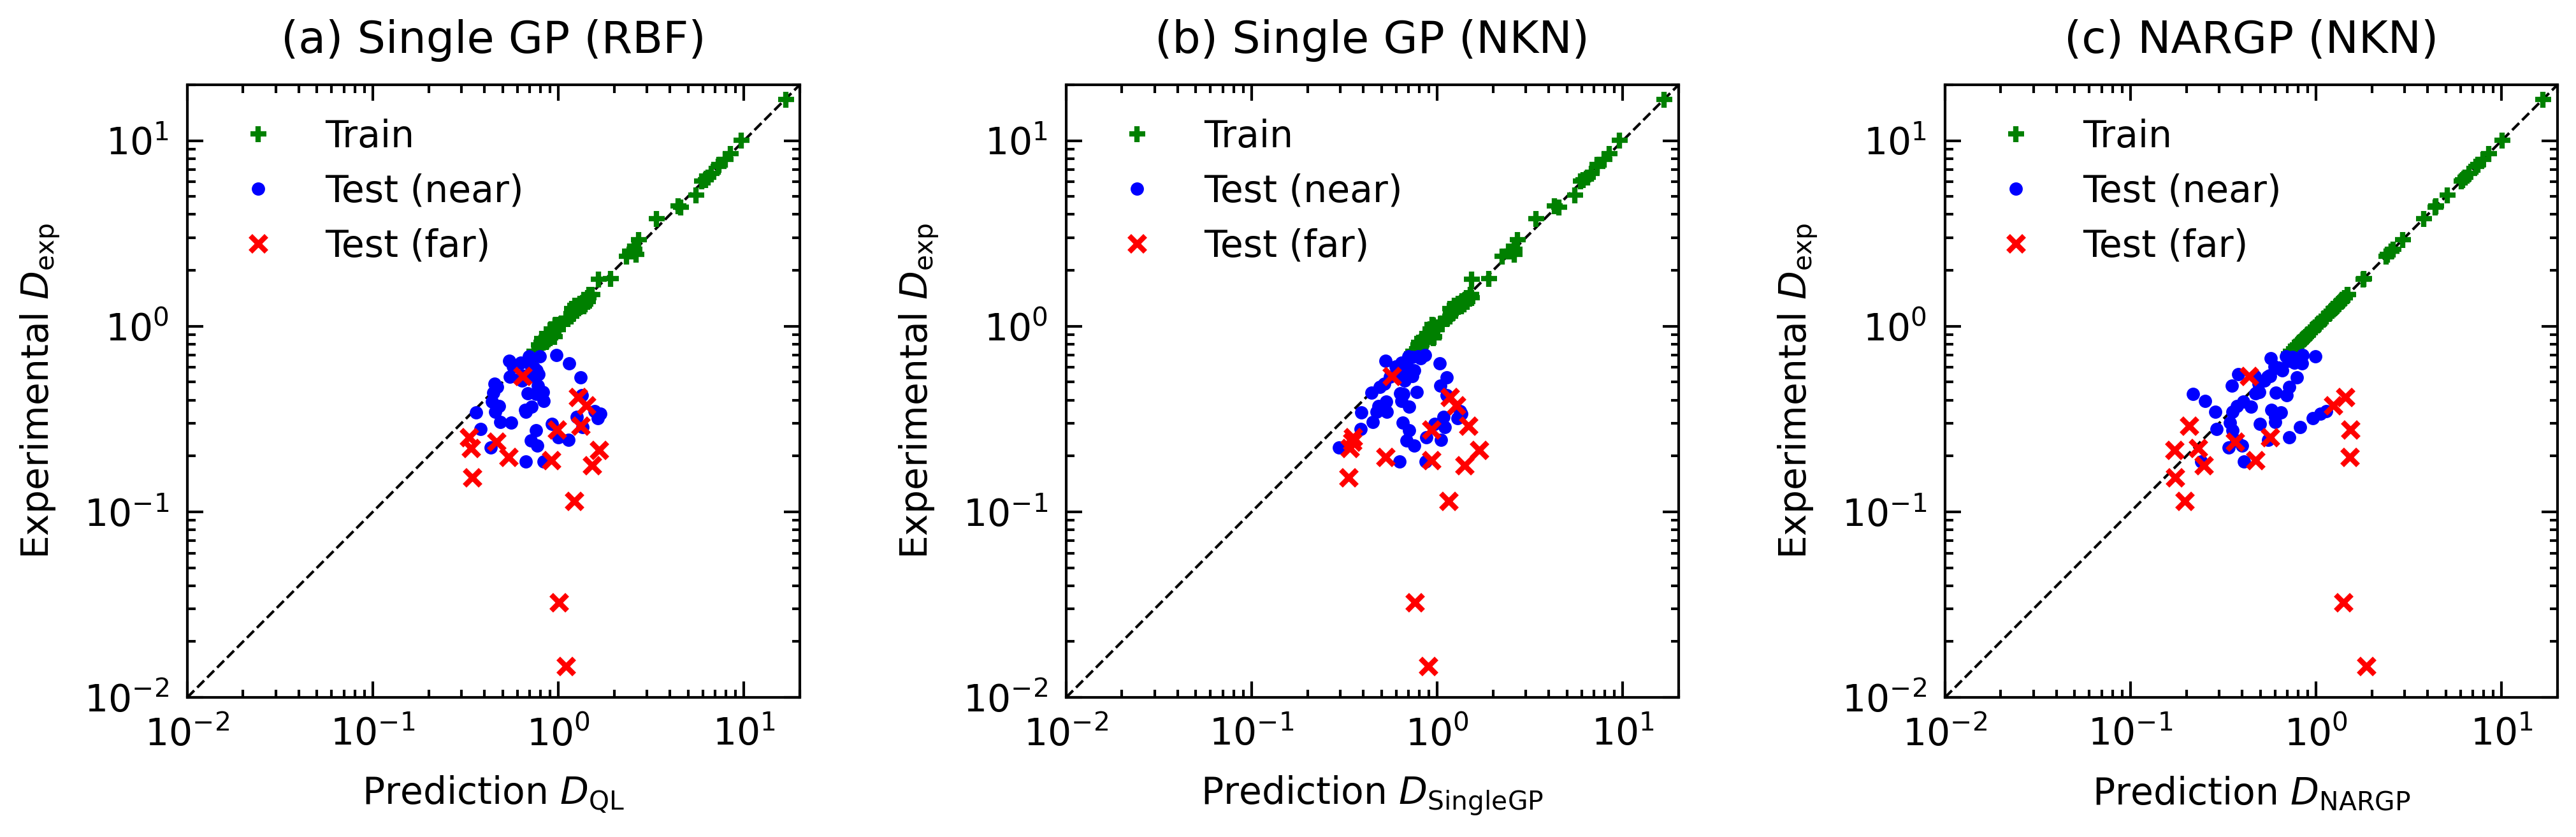

In [12]:
plt.style.use('../nature_style.txt')

fig=plt.figure(figsize=(7,2.2),dpi=600) # figsize=(width,height(inch)),dpi(dots per inch)

ax = fig.add_subplot(1,3,1)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train_list[0]),df_train["D_exp"],"g+",label="Train")
ax.plot(np.exp(mean_test_list[0])[near_list],df_test["D_exp"][near_list],"b.",label="Test (near)")
ax.plot(np.exp(mean_test_list[0])[far_list],df_test["D_exp"][far_list],"rx",label="Test (far)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{QL}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
ax.set_title(r"(a) Single GP (RBF)")
# ax.text(8,0.015,"(a)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

ax = fig.add_subplot(1,3,2)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train_list[1]),df_train["D_exp"],"g+",label="Train")
ax.plot(np.exp(mean_test_list[1])[near_list],df_test["D_exp"][near_list],"b.",label="Test (near)")
ax.plot(np.exp(mean_test_list[1])[far_list],df_test["D_exp"][far_list],"rx",label="Test (far)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{SingleGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
ax.set_title(r"(b) Single GP (NKN)")
# ax.text(8,0.015,"(b)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

ax = fig.add_subplot(1,3,3)
D_min = 0.01 #df["D_exp"].min()
D_max = 20 #df["D_exp"].max()
ax.plot([D_min,D_max],[D_min,D_max],"--",color="k",lw=0.5)
ax.plot(np.exp(mean_train_list[3]),df_train["D_exp"],"g+",label="Train")
ax.plot(np.exp(mean_test_list[3])[near_list],df_test["D_exp"][near_list],"b.",label="Test (near)")
ax.plot(np.exp(mean_test_list[3])[far_list],df_test["D_exp"][far_list],"rx",label="Test (far)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(D_min,D_max)
ax.set_ylim(D_min,D_max)
ax.set_aspect("equal")
ax.set_aspect("equal")
ax.set_xlabel(r"Prediction $D_\mathrm{NARGP}$")
ax.set_ylabel(r"Experimental $D_\mathrm{exp}$")
ax.legend(loc="upper left")
ax.set_title(r"(c) NARGP (NKN)")
# ax.text(8,0.015,"(c)",color="k", fontfamily="sans-serif", fontweight="bold", fontsize=8)

plt.tight_layout()
plt.savefig("fig4.pdf",dpi=600,bbox_inches="tight")
plt.show() 